# Keras LSTM Sequence to sequence model

## introduction

In this notebook i develop a LSTM many to many model with keras for a multivariate timeseries regression. The dataset are Mel-spectrograms of different languages generated in the preprocessing notebook.

The aim is to see the effect of different pretraining using different languages in the encoded space (see linearSVC notebook) and time to convergence to a fixed loss threshold.

The pretraining has been done using low pass filtered spectrograms (check preprocessing notebook).


In [1]:
import os
import datetime
from glob import glob
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm import tqdm
from timeit import default_timer as timer
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import  torch
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")


In [2]:
tf.config.set_visible_devices([], 'GPU') #no gpu

## import dataset

In [5]:
# This function will take care of the dataloading
def load_dataset(folder,normalize,threshold):
    
    dataset = pd.DataFrame()
    
    scaler = MinMaxScaler()
    
    for mel_spec in tqdm(folder):

        #data = torch.load(mel_spec)
        data = np.load(mel_spec)
        
        if normalize is True:
            data = scaler.fit_transform(data)

        data = torch.tensor(data)
        intensity_at_time_step = torch.sum(data, dim=1)
        spectrogram_mean_intensity = torch.mean(intensity_at_time_step)
        
        if spectrogram_mean_intensity < threshold:
            pass
        else:
            #data = torch.transpose(data,0,1)
            data=data.numpy()
            
        dataframe = pd.DataFrame(data.T)
        
        dataset=pd.concat([dataset,dataframe],ignore_index=True)
        
            
    return dataset

In [4]:
# Enter the path where you keep your spectrograms
folder = glob('Neuro/spectrograms/esp_mel_spectrograms/*')
folder = folder[4000:8000] # more than enough for the lstm

filter_folder=glob('Neuro/spectrograms/ita_filter_mel_spectrograms/*')  
filter_folder=filter_folder[200:1000]
# Compiling the dataset
dataset = load_dataset(folder,normalize=True,threshold=0.1)
#compiling filter dataset
filter_dataset = load_dataset(filter_folder,normalize=True,threshold=0.1)

100%|██████████| 800/800 [00:14<00:00, 54.71it/s] 


In [6]:
#load not filtered spectograms of other language for analysis (check svc notebook)
folder2 = glob('Neuro/spectrograms/jap_mel_spectrograms/*')
dataset2 = load_dataset(folder2[:1000],normalize=True,threshold=0.1)


100%|██████████| 1000/1000 [00:11<00:00, 84.74it/s]


## train,test split  ## 



### unfiltered data

In [7]:
train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)
test_data, val_data = train_test_split(test_data, test_size=0.2, shuffle=False)
print(train_data.shape,test_data.shape,val_data.shape)

(691200, 128) (138240, 128) (34560, 128)


### filter data ($f$<500 $Hz$)

In [8]:
train_filter_data, test_filter_data = train_test_split(filter_dataset, test_size=0.2, shuffle=False)
test_filter_data, val_filter_data = train_test_split(test_filter_data, test_size=0.2, shuffle=False)
print(train_filter_data.shape,test_filter_data.shape,val_filter_data.shape)

(138240, 128) (27648, 128) (6912, 128)


### non native

In [9]:
train_data2, test_data2 = train_test_split(dataset2, test_size=0.5, shuffle=False)

windowsgenerator get the indeces and split_windows does the actual splitting. then this two function are called by the keras timeseriesgenerator to make the dataset

In [10]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def get_info(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=216,
            shuffle=True,
            batch_size=64,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.test` dataset
            result = next(iter(self.test))
            # And cache it for next time
            self._example = result
        return result

    def plot(self, model=None, plot_col=10, max_subplots=3):
      inputs, labels = self.example
      plt.figure(figsize=(20, 8))
      plot_col_index = self.column_indices[plot_col]
      max_n = min(max_subplots, len(inputs))
      for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f' feature {plot_col}')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
          label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
          label_col_index = plot_col_index

        if label_col_index is None:
          continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
          predictions = model(inputs)
          plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
          plt.legend()

      plt.xlabel('Time')






### create windows for unfilter and filter data

In [11]:
unfilter_window=WindowGenerator(
    input_width=216, label_width=216, shift=1,train_df=train_data,test_df=test_data,val_df=val_data)


In [12]:
filter_window=WindowGenerator(
    input_width=216, label_width=216, shift=1,train_df=train_filter_data,test_df=test_filter_data,val_df=val_filter_data)


In [13]:
ita_window=WindowGenerator(
        input_width=216, label_width=216, shift=1,train_df=train_data2,test_df=test_data2,val_df=val_filter_data)


The WindowGenerator object holds training, validation, and test data.
Add properties for accessing them as tf.data.Datasets using the make_dataset method defined earlier. Also, add a standard example batch for easy access and plotting.

### lstm model: given t predict t+1 with all the features

![alternatvie text](https://www.tensorflow.org/static/tutorials/structured_data/images/lstm_many_window.png)

In [14]:
lr_schedule = tf.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min')

In [15]:
class new_callback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}): #, lstm_layer
        self.logs=[]  
        self.history = {'loss':[],'val_loss':[]}
       # self.lstm_layer = lstm_layer
       # self.state = {'hidden':[],'cell':[]}
        
    def on_train_begin(self, epoch, logs={}):
        self.starttime = timer()
        
    def on_train_batch_end(self, epoch, logs={}): 
        if(logs.get('loss')< 0.0045): # select the threshold
            print("\n !!! no further training !!!")
            self.model.stop_training = True
            
            
        self.history['loss'].append(logs.get('loss'))
        self.logs.append(timer()-self.starttime)
       
   

callback_stop = new_callback()

In [16]:
num_features=128

inputs = tf.keras.Input(shape=(216, 128))
lstm_output, hidden, cell = tf.keras.layers.LSTM(250, return_sequences=True, return_state=True)(inputs)
dense_output = tf.keras.layers.Dense(units=num_features)(lstm_output)

lstm_model = tf.keras.Model(inputs=inputs, outputs=[dense_output])

model1=tf.keras.Model(inputs=inputs, outputs=[hidden,cell])

lstm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

lstm_model.summary()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 128)]        0         
                                                                 
 lstm (LSTM)                 [(None, 216, 250),        379000    
                              (None, 250),                       
                              (None, 250)]                       
                                                                 
 dense (Dense)               (None, 216, 128)          32128     
                                                                 
Total params: 411128 (1.57 MB)
Trainable params: 411128 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1

### Without pre-training

**stop training when loss reach 0.0045**

In [17]:
history= lstm_model.fit(unfilter_window.train, epochs=20,
                      validation_data=unfilter_window.val,
                      callbacks=[callback_stop]) #prova con early_stopping

Epoch 1/20
50/50 [==============================] - 17s 331ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 2/20
50/50 [==============================] - 17s 335ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 3/20
50/50 [==============================] - 19s 385ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 4/20
50/50 [==============================] - 17s 339ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 5/20
50/50 [==============================] - 17s 333ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/20
50/50 [==============================] - 16s 322ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 7/20
50/50 [====

In [18]:
#total time in seconds
callback_stop.logs[-1]

160.18642116700016

In [19]:
val_performance = {}
performance = {}
val_performance['filter'] = lstm_model.evaluate( unfilter_window.val)
performance['filter'] = lstm_model.evaluate( unfilter_window.test, verbose=0)

print(val_performance,performance)

3/3 [==============================] - 1s 155ms/step - loss: 0.0045 - mean_squared_error: 0.0045
{'filter': [0.004524800460785627, 0.004524800460785627]} {'filter': [0.004847727715969086, 0.004847727715969086]}


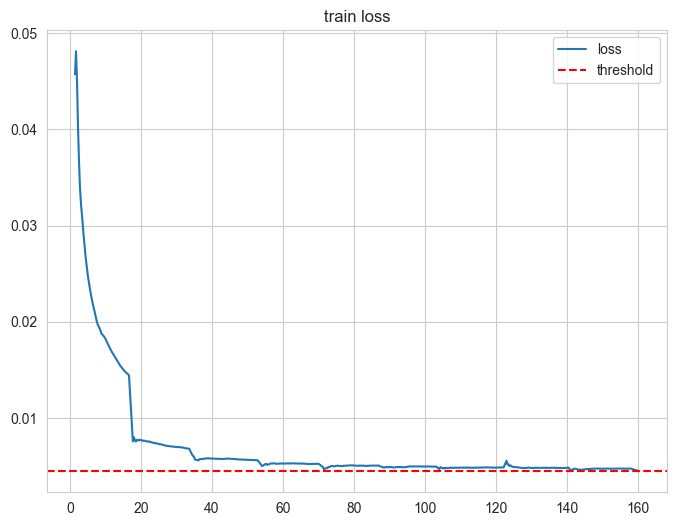

In [20]:
# Plot the history

y1=callback_stop.history['loss'][1:]
#y2=callback_stop.history['val_loss']
#x1 = np.arange( len(y1))
x1=callback_stop.logs[1:]
#k=len(y1)/len(y2)
#x2 = np.arange(k,len(y1)+1,k)
fig, ax = plt.subplots()
line1, = ax.plot(x1, y1, label='loss')
plt.axhline(y = 0.0045, color = 'r', linestyle = '--',label='threshold')
plt.title('train loss')
#line2, = ax.plot(x2, y2, label='val_loss')
#plt.ylim(0,0.0070)
plt.legend()
plt.show()

### *pretrain*: 1 epoch with low filtered spectrograms $f$<500 $Hz$

In [22]:
num_features=128

inputs = tf.keras.Input(shape=(216, 128))
lstm_output, hidden, cell = tf.keras.layers.LSTM(250, return_sequences=True, return_state=True)(inputs)
dense_output = tf.keras.layers.Dense(units=num_features)(lstm_output)

lstm_model_jorge = tf.keras.Model(inputs=inputs, outputs=[dense_output])

#define another model to extract hidden and cell states.
model2=tf.keras.Model(inputs=inputs, outputs=[hidden,cell])

lstm_model_jorge.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

lstm_model_jorge.summary()
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 216, 128)]        0         
                                                                 
 lstm_2 (LSTM)               [(None, 216, 250),        379000    
                              (None, 250),                       
                              (None, 250)]                       
                                                                 
 dense_2 (Dense)             (None, 216, 128)          32128     
                                                                 
Total params: 411128 (1.57 MB)
Trainable params: 411128 (1.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input

In [23]:

history= lstm_model_jorge.fit(filter_window.train, epochs=1,
                      validation_data=filter_window.val,
                      callbacks=[])



10/10 [==============================] - 5s 391ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0092 - val_mean_squared_error: 0.0092


In [26]:
val_performance = {}
performance = {}
val_performance['filter'] = lstm_model_jorge.evaluate( filter_window.val)
performance['filter'] = lstm_model_jorge.evaluate( filter_window.test, verbose=0)


1/1 [==============================] - 0s 143ms/step - loss: 0.0092 - mean_squared_error: 0.0092


### complete training with all frequencies

In [27]:
callback_pretrain=new_callback()

history= lstm_model_jorge.fit(unfilter_window.train, epochs=20,
                      validation_data=unfilter_window.val,
                      callbacks=[callback_pretrain])

Epoch 1/20
50/50 [==============================] - 18s 357ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 2/20
50/50 [==============================] - 19s 384ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 3/20
50/50 [==============================] - 20s 397ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 4/20

 !!! no further training !!!
50/50 [==============================] - 1s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0050 - val_mean_squared_error: 0.0050


In [28]:
print(callback_pretrain.logs[-1]) #spanish

58.06295929199996


In [29]:
val_performance['complete'] = lstm_model_jorge.evaluate( unfilter_window.val)
performance['complete'] = lstm_model_jorge.evaluate( unfilter_window.test, verbose=0)

3/3 [==============================] - 0s 127ms/step - loss: 0.0050 - mean_squared_error: 0.0050


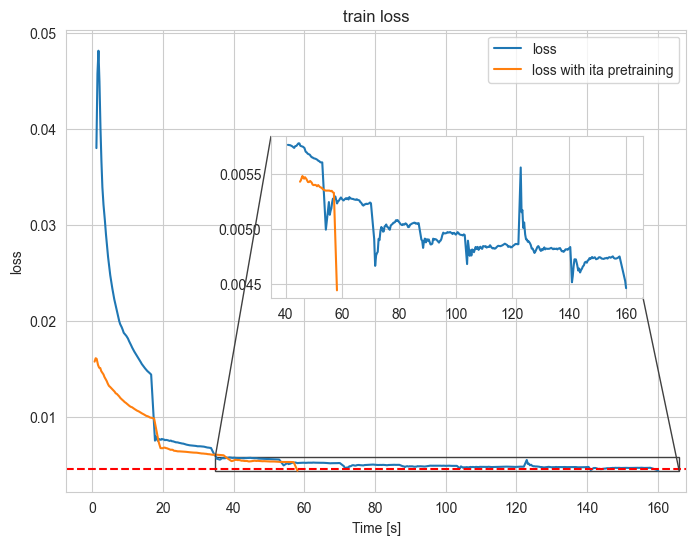

In [33]:
# Plot the history
y0=callback_stop.history['loss']
y1=callback_pretrain.history['loss']
#y2=callback_stop.history['val_loss']
x0=callback_stop.logs
x1 = callback_pretrain.logs
#k=len(y1)/len(y2)
#x2 = np.arange(k,len(y1)+1,k)
fig, ax = plt.subplots()
line0, = ax.plot(x0, y0, label='loss')
line1, = ax.plot(x1, y1, label='loss with ita pretraining')

plt.axhline(y = 0.0046, color = 'r', linestyle = '--')
plt.title('train loss')
#line2, = ax.plot(x2, y2, label='val_loss')
ax.set_xlabel('Time [s]')
ax.set_ylabel('loss')



axins = ax.inset_axes([0.33, 0.42, 0.6, 0.35])
axins.plot(x0[120:],y0[120:] )
axins.plot(x1[120:],y1[120:] )
plt.legend()

# Add border around the zoom inset
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.25")


plt.show()

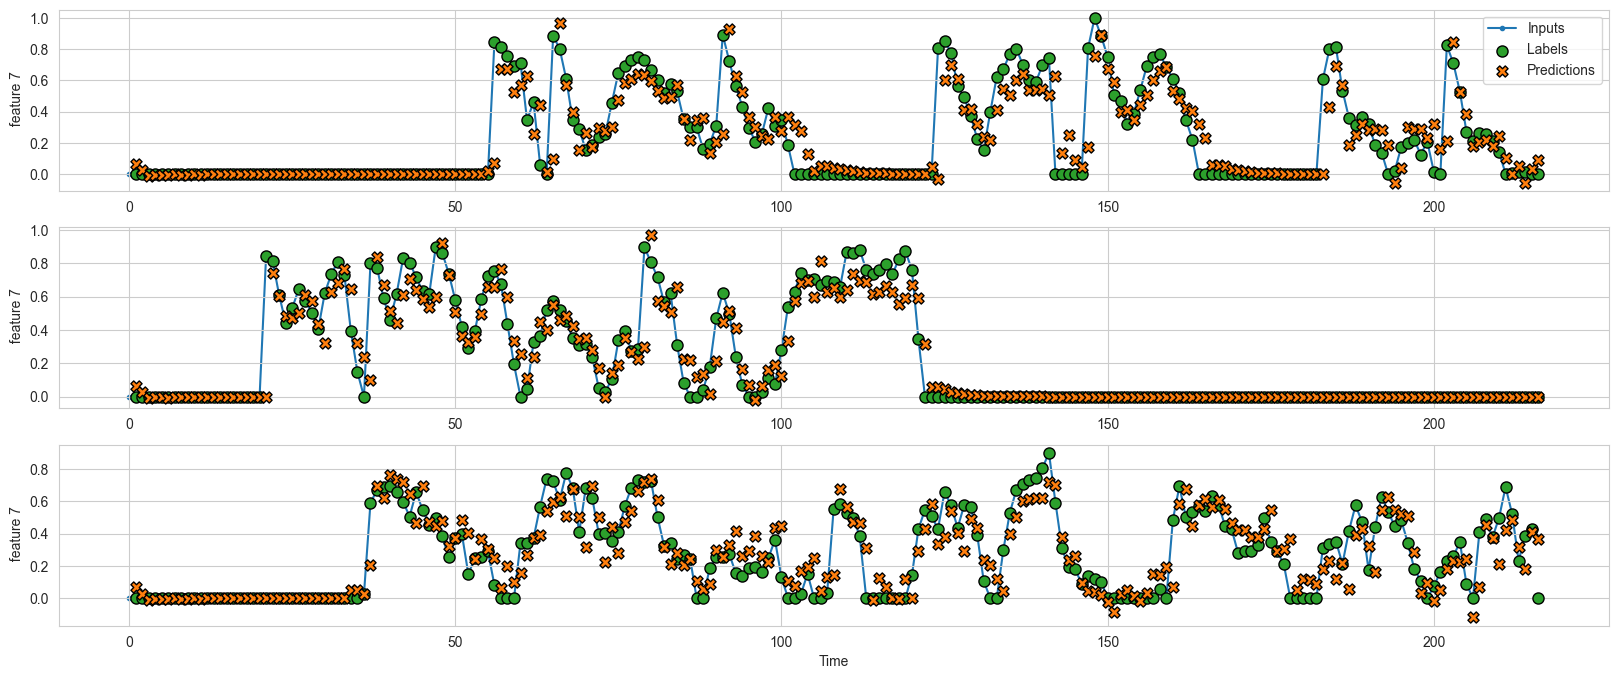

In [ ]:
unfilter_window.plot(lstm_model_jorge,plot_col=7)  #each plot is a different spectogram but the same column

In [35]:


def plot_mel(window,model=None,idx=3):

    idx = idx

    x, lab = window.example  # here there are 32 spectrograms

    X=x[idx].numpy()

    #Original input

    X = np.transpose(X)
    fig_ori, ax = plt.subplots(figsize=(8, 4))
    img = librosa.display.specshow(X)
    ax.set_title('Real Sequence', fontsize=20)
    fig_ori.colorbar(img, ax=ax, format=f'%0.2f dB')

    if model is not None:
        pred=model.predict(window.example[0])

    #predicted spectrograms

    pred=pred[idx]#.numpy()
    pred=np.transpose(pred)
    pred[pred < 0] = 0

    fig_ori, ax = plt.subplots(figsize=(8, 4))
    img = librosa.display.specshow(pred)
    ax.set_title('predicted Sequence', fontsize=20)
    fig_ori.colorbar(img, ax=ax, format=f'%0.2f dB')




2/2 [==============================] - 1s 116ms/step


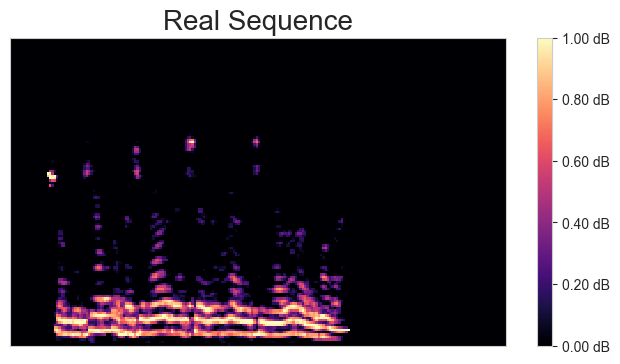

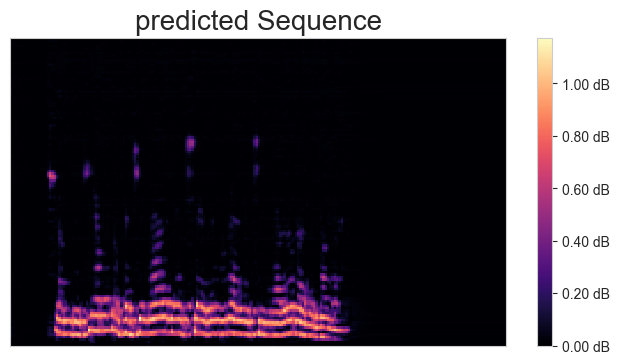

In [36]:
plot_mel(model=lstm_model_jorge,window=unfilter_window,idx=10)

### extract hidden and cell states

In [38]:
hidden=[]
cells=[]

for i,_ in ita_window.test.take(32):
    hid,cel=model1.predict(i)
    hidden.append(hid)
    cells.append(cel)


2/2 [==============================] - 0s 72ms/step


In [40]:
ceee=pd.DataFrame([])
hidd=pd.DataFrame([])

for i in range(len(hidden)):
    
    x=pd.DataFrame(hidden[i])
    y=pd.DataFrame(cells[i])
    
    hidd=pd.concat([hidd,x])
    ceee=pd.concat([ceee,y])

In [42]:
ceee.to_csv('cell_jap_with_no_pretrain.csv')
hidd.to_csv('hidd_jap_with_no_pretrain.csv')


In [112]:
hidd.iloc[:,120:150]

,120,121,122,123,124,125,126,127,128,129,...,140,141,142,143,144,145,146,147,148,149
0,-0.017376,-0.014127,-0.007020,0.020403,-0.052356,0.048195,-0.022141,-0.044539,-0.037957,-0.035606,...,0.047140,0.026385,-0.073488,-0.006328,-0.045638,-0.056568,0.030307,0.025245,0.037391,0.015834
1,0.035472,-0.003922,0.012429,-0.110427,-0.176804,0.040743,0.013378,-0.035406,0.093288,-0.018466,...,0.066918,0.146205,0.066152,0.034452,0.009277,0.076921,0.085426,0.009344,0.002209,0.093702
2,-0.017409,-0.014394,-0.007141,0.020714,-0.052631,0.048496,-0.022234,-0.044942,-0.038052,-0.036189,...,0.047754,0.026305,-0.074247,-0.006505,-0.045955,-0.057067,0.030779,0.025421,0.038136,0.015880
3,-0.018221,-0.017869,-0.009526,0.024085,-0.054426,0.053094,-0.021241,-0.047299,-0.038034,-0.038129,...,0.051152,0.024904,-0.080839,-0.009659,-0.047729,-0.060564,0.032166,0.026846,0.041084,0.016610
4,-0.017376,-0.014130,-0.007021,0.020408,-0.052362,0.048199,-0.022144,-0.044542,-0.037959,-0.035616,...,0.047150,0.026381,-0.073500,-0.006329,-0.045643,-0.056575,0.030315,0.025248,0.037405,0.015831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.017376,-0.014127,-0.007020,0.020403,-0.052356,0.048195,-0.022141,-0.044539,-0.037957,-0.035606,...,0.047140,0.026385,-0.073488,-0.006328,-0.045638,-0.056568,0.030307,0.025245,0.037391,0.015834
60,-0.061790,0.056465,-0.001244,-0.118734,-0.040026,-0.014276,0.049916,-0.043375,-0.114766,-0.028160,...,0.106808,0.169476,0.020254,0.011349,0.007062,-0.069901,0.173569,0.056856,-0.005292,0.128622
61,-0.033638,0.001284,0.004418,-0.030310,-0.031002,0.213372,0.110864,-0.041622,-0.044616,-0.025648,...,0.103182,0.104642,-0.039728,0.019632,0.007563,0.039397,0.065098,-0.016596,-0.004458,0.068349
62,-0.035437,-0.011650,0.023826,-0.093418,-0.132603,0.130677,-0.152148,-0.028528,-0.130403,-0.034557,...,0.097089,0.143135,-0.150393,-0.000144,0.016965,0.142606,0.135531,0.005216,0.063874,0.039845


### Extra: multistep model not working: dropped

In [31]:
num_features=128

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])




multi_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanSquaredError()])

multi_lstm_model.build(input_shape=(32,216,128))
multi_lstm_model.summary()



#full train


history_multi= multi_lstm_model.fit(multi_window.train, epochs=4,
                      validation_data=multi_window.val,
                      callbacks=[early_stopping])

val_performance_multi={}
performance_multi={}
val_performance_multi['complete'] = multi_lstm_model.evaluate( multi_window.val)
performance_multi['complete'] = multi_lstm_model.evaluate( multi_window.test, verbose=0)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (32, 128)                 131584    
                                                                 
 dense_4 (Dense)             (32, 2304)                297216    
                                                                 
 reshape_3 (Reshape)         (32, 18, 128)             0         
                                                                 
Total params: 428800 (1.64 MB)
Trainable params: 428800 (1.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/4


2023-07-12 17:21:58.979772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-12 17:21:59.074382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-12 17:21:59.166555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10799/10799 [==============================] - ETA: 0s - loss: 0.0232 - mean_squared_error: 0.0232

2023-07-12 17:23:42.311757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-12 17:23:42.361568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10799/10799 [==============================] - 106s 10ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 2/4
10799/10799 [==============================] - 104s 10ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0213 - val_mean_squared_error: 0.0213
Epoch 3/4
10799/10799 [==============================] - 105s 10ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 4/4
539/539 [==============================] - 3s 5ms/step - loss: 0.0217 - mean_squared_error: 0.0217


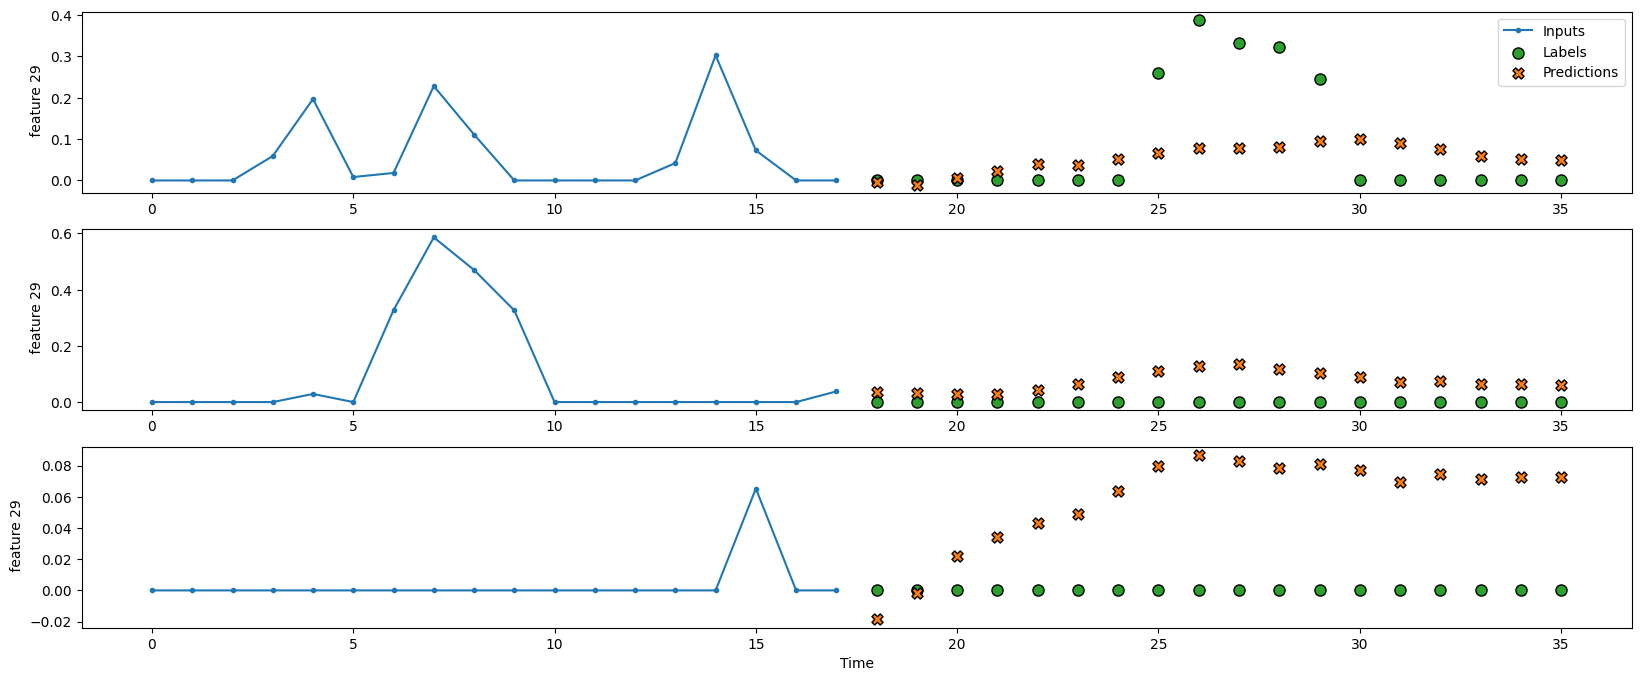

In [56]:
multi_window.plot(multi_lstm_model,plot_col=29)